## L. Roberts "K-State Honor Code "On my honor, as a student, I have neither given nor received unauthorized aid on this academic work.

In [56]:
# import python packages
import requests
from lxml import html
import csv
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import time
from nltk.corpus import stopwords
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

In [57]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Web Crawling 

In [58]:
web = "http://www.apics.org/apics-for-individuals/apics-magazine-home/newsletters/enews/page/"

for page in range(1,5,1):
    print(web + str(page))

http://www.apics.org/apics-for-individuals/apics-magazine-home/newsletters/enews/page/1
http://www.apics.org/apics-for-individuals/apics-magazine-home/newsletters/enews/page/2
http://www.apics.org/apics-for-individuals/apics-magazine-home/newsletters/enews/page/3
http://www.apics.org/apics-for-individuals/apics-magazine-home/newsletters/enews/page/4


In [4]:
alldata = []

web = "http://www.apics.org/apics-for-individuals/apics-magazine-home/newsletters/enews/page/"

for page in range(1,5,1):
    url = (web + str(page))
    data = html.fromstring(requests.get(url).text)
    
    for i in data.xpath("//li[@class='item']"):
        url = i.xpath('div[2]/h3/a/@href')[0]
        alldata.append([url])
    
len(alldata)

80

In [5]:
alldata[:2]

[['../../../magazine-detail-page/2018/02/06/new-tight-delivery-schedule-walmart-suppliers'],
 ['../../../magazine-detail-page/2018/02/06/electric-vehicles-drive-cobalt-demand']]

In [6]:
for i in alldata[:2]:
    url = (i[0].replace('../../..', 'http://www.apics.org/apics-for-individuals/apics-magazine-home'))
    print(url)

http://www.apics.org/apics-for-individuals/apics-magazine-home/magazine-detail-page/2018/02/06/new-tight-delivery-schedule-walmart-suppliers
http://www.apics.org/apics-for-individuals/apics-magazine-home/magazine-detail-page/2018/02/06/electric-vehicles-drive-cobalt-demand


In [7]:
final = []

for i in alldata:
    url = (i[0].replace('../../..', 'http://www.apics.org/apics-for-individuals/apics-magazine-home'))
    data = html.fromstring(requests.get(url).text)
    
    for j in data.xpath("//div[@class='content']"):
        text = j.xpath("p/text()")
        final.append([text])

len(final)

80

In [8]:
final[:1]

[[['Walmart is tightening up policies on its suppliers, dictating that late deliveries to warehouses will receive a fine, ',
   ' reports.\xa0',
   'The previous late-delivery policy was that large suppliers needed to deliver complete orders within one-to-two days 75 percent of the time or incur a 3 percent fine on the cost of the delayed delivery. However, the updated policy will see that delivery threshold increase to 85 percent for large suppliers and increase to 50 percent (from 33 percent) for smaller suppliers. ',
   '"This is not a \'Hey, let\'s see how unreasonable we can be,\'" said Steve Bratspies, chief merchandising officer for Wal-Mart U.S., in an interview with Fox Business. "We need the product that the customer wants when they want it."']]]

## Data Cleaning

In [9]:
df = pd.DataFrame(final)
df.head(2)

,0
0,[Walmart is tightening up policies on its supp...
1,[The demand for cobalt is surging due to the c...


In [10]:
df[0]=df[0].str[0]
df.head(2)

,0
0,Walmart is tightening up policies on its suppl...
1,The demand for cobalt is surging due to the ce...


In [11]:
df = df.rename(columns = {0: 'text'})
df.head(2)

,text
0,Walmart is tightening up policies on its suppl...
1,The demand for cobalt is surging due to the ce...


In [12]:
df['text'] = df['text'].str.lower()
df.head(2)

,text
0,walmart is tightening up policies on its suppl...
1,the demand for cobalt is surging due to the ce...


In [13]:
import nltk
from nltk.corpus import stopwords

df['text'] = df['text'].str.replace('\d+', '')
df['text'] = df.text.str.replace('http\S+|www.\S+', '')
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")
df['text'] = df.text.str.findall('\w{3,}').str.join(' ')

In [14]:
df['text'] = df['text'].fillna("")

In [15]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
more = set(['the', 'this', 'one', 'like', 'even', 'would', 'bad', 'see', 'ever'])
stopwords = set(stopwords) | more 
df['text'] = df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df.head(2)

,text
0,walmart tightening policies suppliers dictatin...
1,demand cobalt surging due cellphone electric v...


## WordCloud

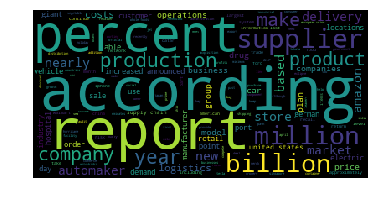

In [16]:
wordcloud = WordCloud().generate(' '.join(df['text']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [17]:
fdist = list(Counter(" ".join(df['text']).split(" ")).items())

freq_word = []

for k,v in fdist:
    freq_word.append([k,v])

wordlist = pd.DataFrame(freq_word)
wordlist.head()

,0,1
0,walmart,4
1,tightening,1
2,policies,2
3,suppliers,6
4,dictating,1


In [18]:
wordlist.sort_values(1, ascending=False).head(10)

,0,1
18,according,16
1067,,14
32,reports,13
354,percent,11
49,million,9
150,production,9
171,company,8
26,billion,8
535,supply,7
157,amazon,7


In [19]:
df['counts'] = df['text'].str.len()
df.head(2)

,text,counts
0,walmart tightening policies suppliers dictatin...,87
1,demand cobalt surging due cellphone electric v...,73


In [20]:
vs = SentimentIntensityAnalyzer()

df['score'] = df['text'].apply(lambda x: vs.polarity_scores(x)['compound'])
df.head(2)

,text,counts,score
0,walmart tightening policies suppliers dictatin...,87,0.2023
1,demand cobalt surging due cellphone electric v...,73,-0.1280


In [21]:
df.groupby(df['score'].apply(lambda x: 'negative' if x < -0.1 else 'positive' if x > 0.1 else 'neutral'))['score'].count()

score
negative    14
neutral     28
positive    38
Name: score, dtype: int64

In [22]:
df['score'].mean()

0.16425874999999998

#### Looks like sentiment is slightly positive overall, but pretty much neutral

In [23]:
text = df['text']
text.head(2)

0    walmart tightening policies suppliers dictatin...
1    demand cobalt surging due cellphone electric v...
Name: text, dtype: object

In [24]:
for i in text[:2]:
    print(i)

walmart tightening policies suppliers dictating late deliveries warehouses receive fine
demand cobalt surging due cellphone electric vehicle industries according


## Bigrams to run Network Analytics

In [25]:
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

import itertools
import collections

# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z]+", " ", text) for text in text]
# tokenize
texts = [[word for word in text.lower().split()] for text in documents]
# stemming words: having --> have; friends --> friend
#lmtzr = WordNetLemmatizer()
#texts = [[lmtzr.lemmatize(word) for word in text] for text in texts]
# remove common words
stoplist = stopwords.words('english')
texts = [[word for word in text if word not in stoplist] for text in texts]
# remove short words
texts = [[word for word in tokens if len(word) >= 3] for tokens in texts]

In [26]:
texts[:2]

[['walmart',
  'tightening',
  'policies',
  'suppliers',
  'dictating',
  'late',
  'deliveries',
  'warehouses',
  'receive',
  'fine'],
 ['demand',
  'cobalt',
  'surging',
  'due',
  'cellphone',
  'electric',
  'vehicle',
  'industries',
  'according']]

In [27]:
terms_bigram = [list(bigrams(i)) for i in texts]

In [28]:
terms_bigram[0]

[('walmart', 'tightening'),
 ('tightening', 'policies'),
 ('policies', 'suppliers'),
 ('suppliers', 'dictating'),
 ('dictating', 'late'),
 ('late', 'deliveries'),
 ('deliveries', 'warehouses'),
 ('warehouses', 'receive'),
 ('receive', 'fine')]

In [29]:
outfile = open("data/finalproject_bigram_network.csv", "w", newline='')
w = csv.writer(outfile)
for i in terms_bigram:
    for j in i:
        w.writerow(j)    
outfile.close()

## Visualize Network

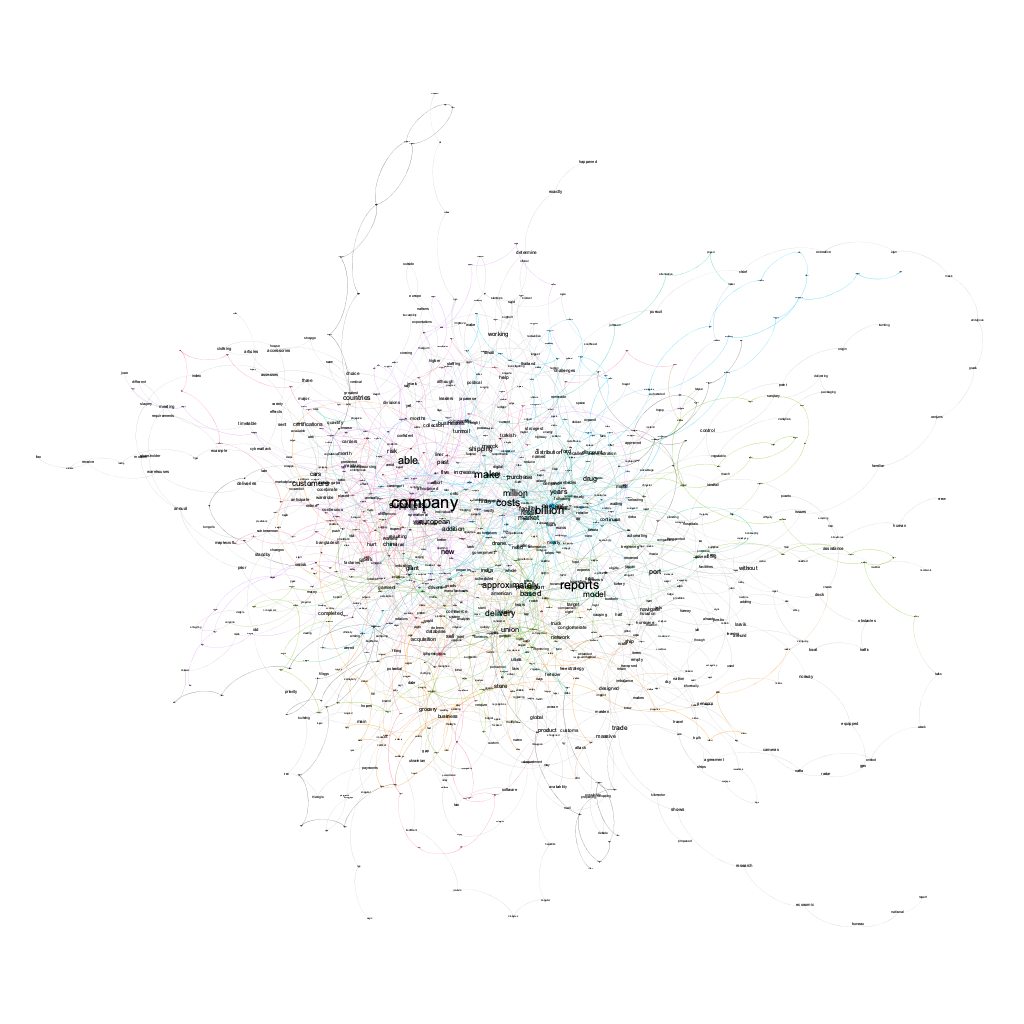

In [55]:
from IPython.display import Image
Image(filename='data/final.png') 

## Topic Modeling

In [30]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import numpy
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # To ignore all warnings that arise here to enhance clarity

In [31]:
texts = df['text']
texts.head(2)

0    walmart tightening policies suppliers dictatin...
1    demand cobalt surging due cellphone electric v...
Name: text, dtype: object

In [32]:
# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z0-9]", " ", document) for document in texts]
# tokenize & lowercase
texts = [document.lower().split() for document in documents]
# stemming words: having --> have; friends --> friend
wordnet_lemmatizer = WordNetLemmatizer()
texts = [[wordnet_lemmatizer.lemmatize(word) for word in tokens] for tokens in texts]
# remove common words
stoplist = stopwords.words('english')
texts = [[word for word in tokens if word not in stoplist] for tokens in texts]
# remove short words
texts = [[ word for word in tokens if len(word) >= 3 ] for tokens in texts]

In [33]:
# A list of extra stopwords specific to the debates transcripts (if you want to remove more stopwords)
extra_stopwords = ['will', 'people', 'need', 'think', 'well','going', 'can', 'country', 'know', 'lot', 'get','make','way','president', 'want',
                'like','say','got','said','just','something','tell','put','now', 'bad','back','want','right','every','one','use','come','never', 
                'many','along','things','day','also','first','guy', 'great', 'take', 'good', 'much','anderson', 'let', 'would', 'year', 'thing', 'america',
                'talk', 'talking', 'thank', 'does', 'give', 'look', 'believe', 'tonight','today','see']

extra_stoplist = extra_stopwords

# remove extra stopwords
texts = [[word for word in tokens if word not in extra_stoplist] for tokens in texts]

In [34]:
dictionary = Dictionary(texts)
dictionary.save('data/final.dict')  # store the dictionary, for future reference

len(dictionary)

969

In [35]:
dictionary.filter_extremes(no_below=2, no_above=0.4) #https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
len(dictionary)

262

In [36]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('data/final.mm', corpus)  # store to disk, for later use  # store to disk, for later use
len(corpus)

80

In [37]:
print(('Number of unique tokens: %d' % len(dictionary)))
print(('Number of documents: %d' % len(corpus)))

Number of unique tokens: 262
Number of documents: 80


In [38]:
saved_dict = dictionary.load('data/final.dict')

In [39]:
corpus_saved = corpora.MmCorpus('data/final.mm')

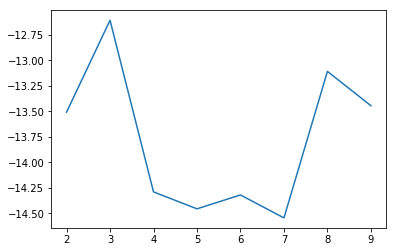

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

numpy.random.seed(1) # setting random seed to get the same results each time.
k_range = range(2,10)
scores = []
for k in k_range:
    goodLdaModel = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=20)
    goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    scores.append(goodcm.get_coherence())
    
plt.figure()
plt.plot(k_range, scores)

The optimal number of topics was 3 so I expect to have 3 main topics, but I wanted to look into 8 because the graph shows that would be good too. 

In [41]:
numpy.random.seed(1) # setting random seed to get the same results each time. 
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=8, passes=20)

In [42]:
model.save('data/final.model')

In [43]:
model.show_topics(num_topics=8)

[(0,
  '0.033*"according" + 0.025*"market" + 0.025*"delivery" + 0.025*"european" + 0.025*"company" + 0.017*"billion" + 0.017*"india" + 0.017*"logistics" + 0.017*"based" + 0.017*"union"'),
 (1,
  '0.033*"store" + 0.025*"amazon" + 0.025*"delivery" + 0.017*"giant" + 0.017*"food" + 0.017*"report" + 0.017*"industry" + 0.017*"acquisition" + 0.017*"com" + 0.017*"grocery"'),
 (2,
  '0.034*"production" + 0.034*"car" + 0.026*"drug" + 0.017*"german" + 0.017*"part" + 0.017*"customer" + 0.017*"system" + 0.017*"japan" + 0.017*"able" + 0.017*"purchase"'),
 (3,
  '0.019*"automaker" + 0.014*"million" + 0.014*"according" + 0.014*"operation" + 0.014*"return" + 0.014*"container" + 0.014*"bag" + 0.014*"hurricane" + 0.014*"port" + 0.014*"nearly"'),
 (4,
  '0.041*"supplier" + 0.031*"report" + 0.031*"model" + 0.021*"information" + 0.021*"million" + 0.021*"facility" + 0.021*"brand" + 0.021*"mitsubishi" + 0.021*"vegetable" + 0.021*"addition"'),
 (5,
  '0.040*"percent" + 0.032*"hospital" + 0.032*"increased" + 0.

In [44]:
for top in model.show_topics(num_topics=8):
  print(top)
print()

(0, '0.033*"according" + 0.025*"market" + 0.025*"delivery" + 0.025*"european" + 0.025*"company" + 0.017*"billion" + 0.017*"india" + 0.017*"logistics" + 0.017*"based" + 0.017*"union"')
(1, '0.033*"store" + 0.025*"amazon" + 0.025*"delivery" + 0.017*"giant" + 0.017*"food" + 0.017*"report" + 0.017*"industry" + 0.017*"acquisition" + 0.017*"com" + 0.017*"grocery"')
(2, '0.034*"production" + 0.034*"car" + 0.026*"drug" + 0.017*"german" + 0.017*"part" + 0.017*"customer" + 0.017*"system" + 0.017*"japan" + 0.017*"able" + 0.017*"purchase"')
(3, '0.019*"automaker" + 0.014*"million" + 0.014*"according" + 0.014*"operation" + 0.014*"return" + 0.014*"container" + 0.014*"bag" + 0.014*"hurricane" + 0.014*"port" + 0.014*"nearly"')
(4, '0.041*"supplier" + 0.031*"report" + 0.031*"model" + 0.021*"information" + 0.021*"million" + 0.021*"facility" + 0.021*"brand" + 0.021*"mitsubishi" + 0.021*"vegetable" + 0.021*"addition"')
(5, '0.040*"percent" + 0.032*"hospital" + 0.032*"increased" + 0.024*"risk" + 0.024*"nea

In [45]:
for i in range(0,8):
    topics = model.show_topic(i, 10)
    print(', '.join([str(word[0]) for word in topics]))

according, market, delivery, european, company, billion, india, logistics, based, union
store, amazon, delivery, giant, food, report, industry, acquisition, com, grocery
production, car, drug, german, part, customer, system, japan, able, purchase
automaker, million, according, operation, return, container, bag, hurricane, port, nearly
supplier, report, model, information, million, facility, brand, mitsubishi, vegetable, addition
percent, hospital, increased, risk, nearly, business, supply, price, cost, retail
company, according, american, group, industry, ford, logistics, supply, supplier, business
product, cost, billion, amazon, new, supplier, price, approximately, trade, walmart


In [46]:
lda_corpus = model[corpus]

results = []
for i in lda_corpus[:8]:
    print(i)
    results.append(i)
print()

[(0, 0.85400665), (1, 0.02085034), (2, 0.020842288), (3, 0.020841515), (4, 0.020902814), (5, 0.020833736), (6, 0.020846944), (7, 0.020875681)]
[(0, 0.01786785), (1, 0.01787017), (2, 0.017858684), (3, 0.017879104), (4, 0.017857354), (5, 0.01785862), (6, 0.8749478), (7, 0.017860416)]
[(0, 0.011385043), (1, 0.0113866525), (2, 0.011375492), (3, 0.9203175), (4, 0.011388202), (5, 0.011389378), (6, 0.011372923), (7, 0.011384819)]
[(0, 0.015642874), (1, 0.015633272), (2, 0.015627105), (3, 0.015626281), (4, 0.015636344), (5, 0.01562957), (6, 0.015635096), (7, 0.8905695)]
[(0, 0.9485074)]
[(3, 0.9649764)]
[(7, 0.94527066)]
[(0, 0.017857613), (1, 0.017865835), (2, 0.017866105), (3, 0.8749026), (4, 0.017857617), (5, 0.017916467), (6, 0.017876176), (7, 0.017857613)]



In [47]:
toptopic = [max(collection, key=lambda x: x[1])[0] for collection in results]
toptopic[:8]

[0, 6, 3, 7, 0, 3, 7, 3]

In [48]:
toptopic = pd.DataFrame(toptopic)
documents = pd.DataFrame(documents)
documents = documents.rename(columns = {0: 'documents'})
summary = documents.join(toptopic)
summary.head()

,documents,0
0,walmart tightening policies suppliers dictatin...,0.0
1,demand cobalt surging due cellphone electric v...,6.0
2,ups plans upgrade delivery network investing n...,3.0
3,brexit negotiators turned attention post brexi...,7.0
4,alibaba taking final steps invest million pune...,0.0


In [49]:
summary.groupby(0).count()

,documents
0,
0.0,2
3.0,3
6.0,1
7.0,2


In [50]:
import pyLDAvis.gensim

In [51]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.098768 -0.035961       1        1  10.638132
1      0.085343 -0.061256       2        1  10.816531
2     -0.096274 -0.027123       3        1  10.367274
3     -0.107084 -0.101500       4        1  20.550680
4     -0.082912  0.015227       5        1   8.006005
5      0.004551  0.164852       6        1  10.949834
6     -0.043659  0.057608       7        1  17.712015
7      0.141266 -0.011846       8        1  10.959527, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
63    Default   6.000000        product   6.000000  30.0000  30.0000
139   Default   9.000000        percent   9.000000  29.0000  29.0000
2     Default   8.000000       supplier   8.000000  28.0000  28.0000
171   Default   5.000000            car   5.000000  27.0000  27.0000
65    Default   6.000000          store   6.000000  26.0000  26.0000
67    Default   4.000000       hospital   4.000000  25.0000  25.0000
136   Default   4.000000      increased   4.000000  24.0000  24.0000
0     Default   7.000000       delivery   7.000000  23.0000  23.0000
127   Default   5.000000          model   5.000000  22.0000  22.0000
74    Default   7.000000     production   7.000000  21.0000  21.0000
15    Default   6.000000         nearly   6.000000  20.0000  20.0000
57    Default   5.000000           cost   5.000000  19.0000  19.0000
76    Default   6.000000         amazon   6.000000  18.0000  18.0000
95    Default   5.000000          group   5.000000  17.0000  17.0000
200   Default   5.000000           drug   5.000000  16.0000  16.0000
237   Default   3.000000           risk   3.000000  15.0000  15.0000
107   Default   3.000000          month   3.000000  14.0000  14.0000
87    Default   4.000000       european   4.000000  13.0000  13.0000
12    Default   3.000000       facility   3.000000  12.0000  12.0000
56    Default  11.000000        company  11.000000  11.0000  11.0000
5     Default  13.000000      according  13.000000  10.0000  10.0000
29    Default   4.000000          giant   4.000000   9.0000   9.0000
153   Default   4.000000         german   4.000000   8.0000   8.0000
59    Default   5.000000         market   5.000000   7.0000   7.0000
94    Default   2.000000          brand   2.000000   6.0000   6.0000
175   Default   3.000000    information   3.000000   5.0000   5.0000
233   Default   2.000000      vegetable   2.000000   4.0000   4.0000
62    Default   5.000000          price   5.000000   3.0000   3.0000
33    Default   5.000000      logistics   5.000000   2.0000   2.0000
49    Default   2.000000     mitsubishi   2.000000   1.0000   1.0000
36     Topic1   1.565885        service   2.233888   1.8854  -4.0885
31     Topic1   1.566061          india   2.986456   1.5952  -4.0884
27     Topic1   1.565903       commerce   2.989107   1.5942  -4.0885
87     Topic1   2.302807       european   4.534389   1.5632  -3.7028
24     Topic1   1.565963          union   3.792292   1.3563  -4.0884
59     Topic1   2.302897         market   5.973516   1.2876  -3.7028
1      Topic1   0.828945         policy   2.194636   1.2671  -4.7245
152    Topic1   0.828884         create   2.194646   1.2670  -4.7246
91     Topic1   0.829001         monday   2.244351   1.2448  -4.7245
21     Topic1   0.828988     negotiator   2.244351   1.2448  -4.7245
256    Topic1   0.828987            cut   2.244354   1.2448  -4.7245
155    Topic1   0.828916        rolling   2.244355   1.2447  -4.7246
149    Topic1   0.828909            aim   2.244355   1.2447  -4.7246
223    Topic1   0.828979      completed   2.244574   1.2446  -4.7245
80     Topic1   0.829017         online   2.249558   1.2425  -4.7244
260    Topic1   0.828989      political   2.249563   1.2424  -4.7245
213    Topic1   0.828981     commercial   2.249562   1.2424  -4.7245
235    Topic1   0.828973            

# Story Telling

This topic modeling looks to be very interesting. As you can see it looks like the data collected can be put into 3 main clusters, that are broken down into slightly different topics from the model.

Cluster 1 (including topics 3,4,5, and 7): Very production based text data. Talking alot about automakers and car companies. This data will be talking about problems and concerns with the production plants.

Cluster 2 (including topics 1,2, and 8): Very retail focused text data. Amazon and Walmart are mentioned many times. This data will be talking alot about how these companies are using their superior techniques to their advantage.

Cluster 3 (including topic 6): Talking about hosptial. This topic interested me a great deal, because I was not expecting this at all. Maybe this is possibly an upcoming area where supply chains are becoming more important. 

### Implications

#### Cluster 1
The auto industry will always rely heavily on supply chain capabilities because of the massive number of parts needed for cars. Also the geographical distance of these suppliers sending parts to the manufacturers. Companies are constantly looking for better deals and ways to make these vehicles more efficient. This cluster of supply chain probelms will become very interesting to watch in the near future with eletric cars coming into play. Electric cars require significantly less parts than traditional cars. Supply chain for this new technology could change alot as far as what their daily tasks and focus will be. 

#### Cluster 2
Retailers such as Walmart and Amazon rely heavily on their supply chain capabilities to help them be successful companies. Logistics and warehousing are becoming increasingly important for companies such as these because of the large demand for an online presence. Walmart and Amazon are constantly battling with the balance of having a large variety of products while also having the inventory capacitiy to handle demand for very popular products. 

This analysis can be simplified by optimizing inventory by looking at which products might provide better margins, take up more space, and how fast certian products are moving. I believe from this analysis that this cluster will be heavily changed by technology innovation and AI (artifical inteligence). Above there was proof of innovation popping up a few times as well as other words hinting around about efficieny.

#### Cluster 3
I think this cluster is the most interesting from my findings. As a supply chain student I have only heard about opportunity in this industry a few times and didnt really ocnsider it to be a career field to focus on. Hospitals makes sense though, especially with the rapidly growing elderly population. More and more people will be needing hospital help. This willl lead to more supplies being needed an resources of all kinds. 

Hopefully as far as the hospital and healthcare industry goes they recognize this trend and start to prepare. Supply chain capabilities could save these companies millions of dollars if implemented properly. And universities shoudl recognize this industry as an up and coming opportunity. They could start by using real life examples from healthcare industry problems. Partnerships with companies belonging to this specific industry could be a start. 

#### Conclusion
Another overlying topic is always international involvment. This will always be an important thing when talking about supply chains. Technology has allowed us to become more connected with other countries and use eachothers resources to help everyone within the supply chain. I believe that invloving more international content for students and employees could help perspective. 

International involvement doesnt end with a countries resources. Trade deals and international economics are also very important to the success of a supply chain as well. Exchange rates can deminish profits or help them, which is a huge concern for companies. 